In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

# Importing data


In [ ]:
datapath = f'/content/drive/My Drive/IMDB-Dataset.csv/IMDB-Dataset.csv'
df = pd.read_csv(datapath)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


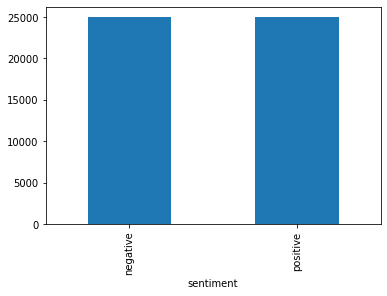

In [ ]:
df.groupby(['sentiment']).size().plot.bar()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'negative':0,
          'positive':1
          }
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        self.labels = torch.FloatTensor(y['sentiment'].values)
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in x['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
df = df.replace({'positive':1,'negative':0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Data Preprocessing


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import string
from typing_extensions import final
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
stop = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')


htmlRGX = re.compile('<.*?>') 
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def data_preprocessing(text):
  sentence = re.sub(htmlRGX, ' ', text)
  sentence = "".join([char for char in sentence if char not in string.punctuation])
  sentence = sentence.lower()
  sentence = sentence.split(' ')
  sentence = [word for word in sentence if word not in stop_words]
  sentence = [lemmatizer.lemmatize(word=word,pos='v') for word in sentence]
  sentence = ' '.join(sentence)
  return sentence

reviews = df['review']
Duplicates = df[reviews.isin(reviews[reviews.duplicated()])].sort_values("review")
#df.drop_duplicates(inplace = True)
df.count()

preprocessed_data= df.copy()
preprocessed_data['review'] = preprocessed_data['review'].apply(data_preprocessing)


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
preprocessed_data.head()

,review,sentiment
0,one reviewers mention watch 1 oz episode youll...,1
1,wonderful little production film technique u...,1
2,think wonderful way spend time hot summer week...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stun f...,1


In [ ]:
unprocessed_data=df.copy()
unprocessed_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


# Defining the model


In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768,512)
        self.relu1=nn.ReLU()
        self.linear2 = nn.Linear(512,256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128,64)
        self.linear5 = nn.Linear(64,1)
        self.sigmoid_final = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        out= self.linear1(dropout_output)
        out= self.relu1(out)
        out= self.linear2(out)
        out= self.relu1(out)
        out= self.linear3(out)
        out= self.relu1(out)
        out= self.linear4(out)
        out= self.relu1(out)
        out= self.linear5(out)
        out= self.relu1(out)
        out= self.sigmoid_final(out)
        return out

# Splitting the data


**Splitting the unprocessed data:**

In [ ]:
from sklearn.model_selection import train_test_split
x, y = unprocessed_data.iloc[:, :-1], unprocessed_data.iloc[:, [-1]] 
xup_train, xup_remaining, yup_train, yup_remaining = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)
xup_validate, xup_test, yup_validate, yup_test = train_test_split(xup_remaining, yup_remaining, train_size=1/3, test_size=2/3,stratify=yup_remaining)
trainup_df, validationup_df = Dataset(xup_train,yup_train), Dataset(xup_validate,yup_validate)
trainup_dataloader = torch.utils.data.DataLoader(trainup_df, batch_size=16, shuffle=True)
validationup_dataloader = torch.utils.data.DataLoader(validationup_df, batch_size=16)

**Splitting the preprocessed data:**

In [ ]:
x, y = preprocessed_data.iloc[:, :-1], preprocessed_data.iloc[:, [-1]] 
xp_train, xp_remaining, yp_train, yp_remaining = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)
xp_validate, xp_test, yp_validate, yp_test = train_test_split(xp_remaining, yp_remaining, train_size=1/3, test_size=2/3,stratify=yp_remaining)
trainp_df, validationp_df = Dataset(xp_train,yp_train), Dataset(xp_validate,yp_validate)
trainp_dataloader = torch.utils.data.DataLoader(trainp_df, batch_size=16, shuffle=True)
validationp_dataloader = torch.utils.data.DataLoader(validationp_df, batch_size=16)

## Training the preprocessed data

function train for the preprocessed data:

In [ ]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs,start):
    global train_accuracy,validation_accuarcy,train_loss,validation_loss

    use_cuda = torch.cuda.is_available() 
    device = torch.device("cuda" if use_cuda else "cpu") 

    criterion = nn.BCELoss() 
    optimizer = Adam(model.parameters(), lr= learning_rate) 


    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader): 

                train_label = train_label.to(device) 
                mask = train_input['attention_mask'].to(device) 
                input_id = train_input['input_ids'].squeeze(1).to(device) 

                output = model(input_id, mask) 
                batch_loss = criterion(output, train_label.unsqueeze(1))
                total_loss_train += batch_loss.item()
                output      = (output >0.5).float()
                train_label = train_label.unsqueeze(1)
                
                acc = (output == train_label).sum().item() 
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward() 
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad(): 

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    
                    batch_loss = criterion(output, val_label.unsqueeze(1))
                    total_loss_val += batch_loss.item()

                    output      = (output >0.5).float()
                    val_label = val_label.unsqueeze(1)
                    
                    acc = (output == val_label).sum().item()
                    total_acc_val += acc
            
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Review/Models/unprocessed_{learning_rate}/epoch_{epoch_num+1+start}/model.pt')
            print(
                f'Epochs: {epoch_num + 1+start} | Train Loss: {16*(total_loss_train / len(train_dataloader.dataset)): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader.dataset): .3f} \
                | Validation Loss: {16*(total_loss_val / len(val_dataloader.dataset)): .3f} \
                | Validation Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            train_accuracy.append( total_acc_train/len(train_dataloader.dataset))
            validation_accuarcy.append( total_acc_val/len(val_dataloader.dataset) )
            train_loss.append(16*(total_loss_train/len(train_dataloader.dataset)))
            validation_loss.append(16*(total_loss_val/len(val_dataloader.dataset)))

            np.save(f'/content/drive/MyDrive/Review/Models/unprocessed_{learning_rate}/epoch_{epoch_num+1+start}/trainLoss.npy', train_loss)
            np.save(f'/content/drive/MyDrive/Review/Models/unprocessed_{learning_rate}/epoch_{epoch_num+1+start}/trainAcc.npy', train_accuracy)
            np.save(f'/content/drive/MyDrive/Review/Models/unprocessed_{learning_rate}/epoch_{epoch_num+1+start}/valLoss.npy', validation_loss)
            np.save(f'/content/drive/MyDrive/Review/Models/unprocessed_{learning_rate}/epoch_{epoch_num+1+start}/valAcc.npy', validation_accuarcy)







In [ ]:
import pickle 
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import os

epochs=1
Lrs=[0.5e-3, 1e-3, 0.5e-4, 1e-4,0.5e-5, 1e-5,0.5e-6, 1e-6] #used in tuning

train_accuracy = []
validation_accuarcy = []
train_loss = []
validation_loss = []
train_accuracy_compare = []
validation_accuarcy_compare = []
train_loss_compare = []
val_loss_compare = []

#for LR in Lrs : 
#    for _ in range(0,100):
#        gc.collect() # delete unwanted objects
#        torch.cuda.empty_cache() # release unoccupied cached memory
#    try:
#      os.makedirs(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}')
#    except:
#      pass

In [ ]:
Pmodel = BertClassifier()
LR= 1e-06

epochs=2
Pmodel.load_state_dict(torch.load(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/epoch_3/model.pt'))

train(Pmodel,trainp_dataloader, validationp_dataloader, LR , epochs,3)

#PATH = f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/Pmodel.pth'
#torch.save(Pmodel, PATH)
train_accuracy_compare.append(train_accuracy[-1])
validation_accuarcy_compare.append(validation_accuarcy[-1])

train_loss_compare.append(train_loss[-1])
val_loss_compare.append(validation_loss[-1])


with open(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/train_accuracy_{LR}','wb+') as f: 
          pickle.dump( np.array(train_accuracy), f)

with open(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/validation_accuarcy_{LR}','wb+') as f: 
          pickle.dump( np.array(validation_accuarcy), f)

with open(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/train_loss_{LR}','wb+') as f: 
          pickle.dump( np.array(train_loss), f)

with open(f'/content/drive/MyDrive/Review/Models/preprocessed_{LR}/validation_loss_{LR}','wb+') as f: 
          pickle.dump( np.array(validation_loss), f)

epochs  =  [i for i in range(0,len(validation_loss))]
fig , (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'PModel plot')
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])
ax1.plot(epochs, validation_loss,'g',epochs,train_loss,'b')
ax2.set_ylim([0, 1])
ax1.set_xlim([0, 1])
ax2.plot(epochs,validation_accuarcy,'g',epochs,train_accuracy,'b')
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png')  



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 6/2188 [00:10<1:03:29,  1.75s/it]


KeyboardInterrupt: ignored

**graphs representing the change of training and validation accuracies with the number of training epochs:**

Learning rate = 0.001

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.001/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_0.001/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.001/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.001/epoch_2/valAcc.npy",allow_pickle=True)

In [ ]:
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2

In [ ]:
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)

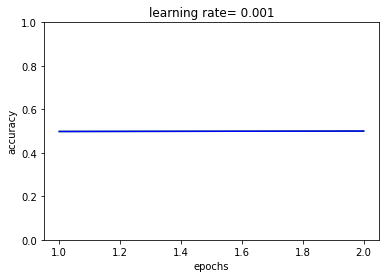

In [ ]:
LR=0.001
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
ax1.set_ylim([0, 1])
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.001")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 0.0001

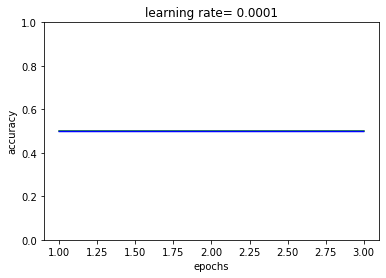

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0001/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0001/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0001/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0001/epoch_2/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=0.0001
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
ax1.set_ylim([0, 1])
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.0001")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png') 


Learning rate = 0.0005

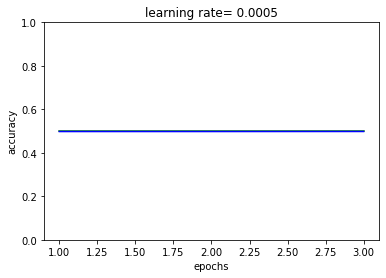

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0005/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0005/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0005/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0005/epoch_2/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=0.0005
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.0005")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 5e-05:

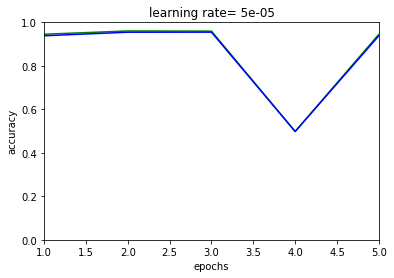

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_5/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_5/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=5e-05
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.title("learning rate= 5e-05")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png') 

Learning rate= 1e-05

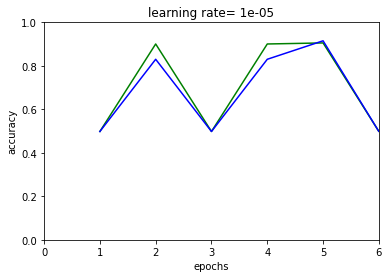

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_5/trainAcc.npy",allow_pickle=True)
train_accuracy_6= np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_6/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_6 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_6/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
ltrain_accuracy_6=list(train_accuracy_6)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
lval_accuracy_6=list(val_accuracy_6)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 + ltrain_accuracy_6
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 + lval_accuracy_6
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=1e-05
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 6])
plt.title("learning rate= 1e-05")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 1e-06:

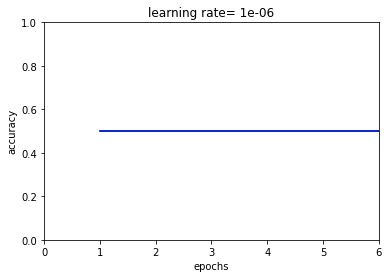

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_5/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_5/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=1e-06
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 6])
plt.title("learning rate= 1e-06")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png')

Learning rate = 5e-06:


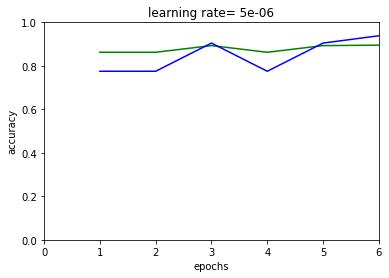

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_5/trainAcc.npy",allow_pickle=True)
train_accuracy_6= np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_6/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_6 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_6/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
ltrain_accuracy_6=list(train_accuracy_6)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
lval_accuracy_6=list(val_accuracy_6)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 + ltrain_accuracy_6
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 + lval_accuracy_6
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=5e-06
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 6])
plt.title("learning rate= 5e-06")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/preprocessed_{LR}/Pmodel_graph_.png')

**the best validation accuracies for thedifferent values of learning rate:**

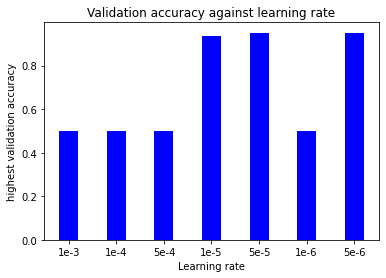

In [ ]:
val_accuracy_001 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.001/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_0001 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0001/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_0005 = np.load("/content/drive/My Drive/Review/Models/preprocessed_0.0005/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_1eneg5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-05/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_5eneg5 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-05/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_1eneg6 = np.load("/content/drive/My Drive/Review/Models/preprocessed_1e-06/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_5eneg6 = np.load("/content/drive/My Drive/Review/Models/preprocessed_5e-06/epoch_6/valAcc.npy",allow_pickle=True)
accuracies=[0.5,0.498,0.498,0.934,0.95,0.5,0.951]
lrs=["1e-3", "1e-4","5e-4","1e-5","5e-5","1e-6","5e-6"]
plt.bar(np.array(lrs),np.array(accuracies),  color ='blue',width = 0.4)
plt.xlabel("Learning rate")
plt.ylabel("highest validation accuracy")
plt.title("Validation accuracy against learning rate")
plt.show()








# Training the unprocessed data:

In [ ]:
import pickle 
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import os

epochs=1
Lrs=[1e-3, 0.5e-4, 1e-4,0.5e-5, 1e-5,0.5e-6, 1e-6] #used in tuning

train_accuracy = []
validation_accuarcy = []
train_loss = []
validation_loss = []
train_accuracy_compare = []
validation_accuarcy_compare = []
train_loss_compare = []
val_loss_compare = []

In [ ]:
Pmodel = BertClassifier()
LR= 1e-6
Pmodel.load_state_dict(torch.load(f'/content/drive/MyDrive/Review/Models/unprocessed_{LR}/epoch_5/model.pt'))

train(Pmodel,trainup_dataloader, validationup_dataloader, LR , epochs,5)

#PATH = f'/content/drive/MyDrive/Review/Models/unprocessed_{LR}/Pmodel.pth'
#torch.save(Pmodel, PATH)
train_accuracy_compare.append(train_accuracy[-1])
validation_accuarcy_compare.append(validation_accuarcy[-1])

train_loss_compare.append(train_loss[-1])
val_loss_compare.append(validation_loss[-1])


with open(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/train_accuracy_{LR}','wb+') as f: 
          pickle.dump( np.array(train_accuracy), f)

with open(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/validation_accuarcy_{LR}','wb+') as f: 
          pickle.dump( np.array(validation_accuarcy), f)

with open(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/train_loss_{LR}','wb+') as f: 
          pickle.dump( np.array(train_loss), f)

with open(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/validation_loss_{LR}','wb+') as f: 
          pickle.dump( np.array(validation_loss), f)

epochs  =  [i for i in range(0,len(validation_loss))]
fig , (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f'PModel plot')
ax1.set_ylim([0, 1])
ax1.plot(epochs, validation_loss,'g',epochs,train_loss,'b')
ax2.set_ylim([0, 1])
ax2.plot(epochs,validation_accuarcy,'g',epochs,train_accuracy,'b')
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png') 


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2188/2188 [13:05<00:00,  2.79it/s]


RuntimeError: ignored

**graphs representing the change of training and validation accuracies with the number of training epochs:**

Learning rate = 0.001

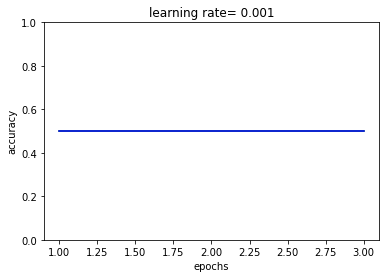

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.001/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_0.001/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.001/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.001/epoch_2/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=0.001
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
ax1.set_ylim([0, 1])
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.001")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png')




Learning rate = 0.0001

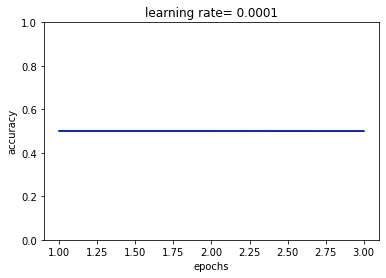

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0001/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0001/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0001/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0001/epoch_2/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=0.0001
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
ax1.set_ylim([0, 1])
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.0001")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png')

Learning rate = 0.0005

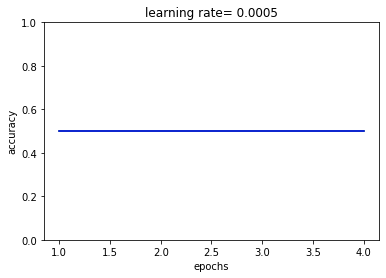

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0005/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0005/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0005/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0005/epoch_2/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=0.0005
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
ax1.set_ylim([0, 1])
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.title("learning rate= 0.0005")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png')

Learning rate = 1e-5:

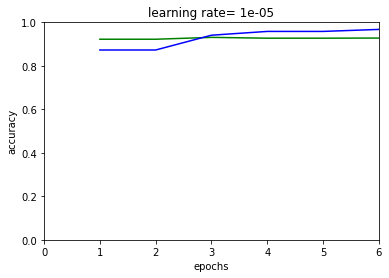

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_5/trainAcc.npy",allow_pickle=True)
train_accuracy_6= np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_6/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_6 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_6/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
ltrain_accuracy_6=list(train_accuracy_6)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
lval_accuracy_6=list(val_accuracy_6)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 + ltrain_accuracy_6
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 + lval_accuracy_6
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=1e-05
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 6])
plt.title("learning rate= 1e-05")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 5e-5:

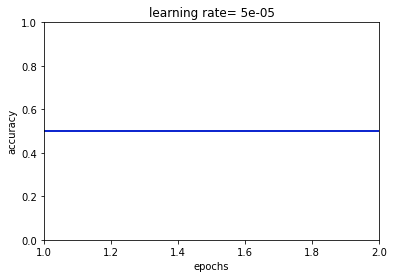

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-05/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-05/epoch_2/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-05/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-05/epoch_2/valAcc.npy",allow_pickle=True)

ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)

lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)

ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2
lval_accuracy = lval_accuracy_1 + lval_accuracy_2
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=5e-05
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([1, 2])
plt.title("learning rate= 5e-05")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 1e-6:

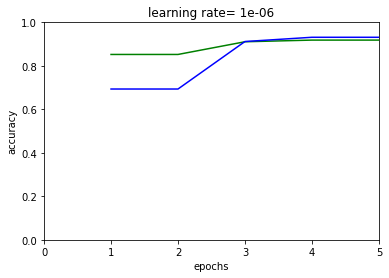

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_5/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_5/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=1e-06
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 5])
plt.title("learning rate= 1e-06")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png') 

Learning rate = 5e-6

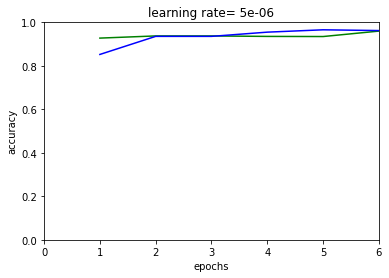

In [ ]:
train_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_1/trainAcc.npy",allow_pickle=True)
train_accuracy_2= np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_2/trainAcc.npy",allow_pickle=True)
train_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_3/trainAcc.npy",allow_pickle=True)
train_accuracy_4= np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_4/trainAcc.npy",allow_pickle=True)
train_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_5/trainAcc.npy",allow_pickle=True)
train_accuracy_6= np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_6/trainAcc.npy",allow_pickle=True)
val_accuracy_1 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_1/valAcc.npy",allow_pickle=True)
val_accuracy_2 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_3 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_3/valAcc.npy",allow_pickle=True)
val_accuracy_4 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_4/valAcc.npy",allow_pickle=True)
val_accuracy_5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_6 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_6/valAcc.npy",allow_pickle=True)
ltrain_accuracy_1=list(train_accuracy_1)
ltrain_accuracy_2=list(train_accuracy_2)
ltrain_accuracy_3=list(train_accuracy_3)
ltrain_accuracy_4=list(train_accuracy_4)
ltrain_accuracy_5=list(train_accuracy_5)
ltrain_accuracy_6=list(train_accuracy_6)
lval_accuracy_1=list(val_accuracy_1)
lval_accuracy_2=list(val_accuracy_2)
lval_accuracy_3=list(val_accuracy_3)
lval_accuracy_4=list(val_accuracy_4)
lval_accuracy_5=list(val_accuracy_5)
lval_accuracy_6=list(val_accuracy_6)
ltrain_accuracy=ltrain_accuracy_1 + ltrain_accuracy_2+ltrain_accuracy_3 + ltrain_accuracy_4+ltrain_accuracy_5 + ltrain_accuracy_6
lval_accuracy = lval_accuracy_1 + lval_accuracy_2+lval_accuracy_3 + lval_accuracy_4+lval_accuracy_5 + lval_accuracy_6
train_accuracies= np.array(ltrain_accuracy)
val_accuracies= np.array(lval_accuracy)
LR=5e-06
epochs  =  [i for i in range(1,len(lval_accuracy)+1)]
plt.plot(epochs, val_accuracies,'g',epochs,train_accuracies,'b')
plt.ylim([0, 1])
plt.xlim([0, 6])
plt.title("learning rate= 5e-06")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig(f'/content/drive/My Drive/Review/Models/unprocessed_{LR}/Pmodel_graph_.png') 

**the best validation accuracies for the different values of learning rate:**

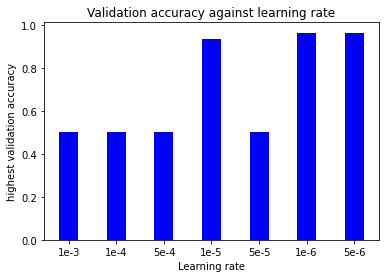

In [ ]:
val_accuracy_001 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.001/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_0001 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0001/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_0005 = np.load("/content/drive/My Drive/Review/Models/unprocessed_0.0005/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_1eneg5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-05/epoch_6/valAcc.npy",allow_pickle=True)
val_accuracy_5eneg5 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-05/epoch_2/valAcc.npy",allow_pickle=True)
val_accuracy_1eneg6 = np.load("/content/drive/My Drive/Review/Models/unprocessed_1e-06/epoch_5/valAcc.npy",allow_pickle=True)
val_accuracy_5eneg6 = np.load("/content/drive/My Drive/Review/Models/unprocessed_5e-06/epoch_6/valAcc.npy",allow_pickle=True)
accuracies=[0.5,0.5,0.5,0.933,0.5,0.96,0.963]
lrs=["1e-3", "1e-4","5e-4","1e-5","5e-5","1e-6","5e-6"]
plt.bar(np.array(lrs),np.array(accuracies),  color ='blue',width = 0.4)
plt.xlabel("Learning rate")
plt.ylabel("highest validation accuracy")
plt.title("Validation accuracy against learning rate")
plt.show()

# The functions of testing:

In [ ]:
from sklearn import metrics

def report(y_test, y_pred):
    c_m = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = c_m, display_labels = [False, True])
    cm_display.plot()
    plt.show()
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}\n")
    print('Report:')
    print(f"{metrics.classification_report(y_test, y_pred)}\n", )

def evaluate(model, test_data):
    test = Dataset(test_data[0],test_data[1])
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    y_pred=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask        = test_input['attention_mask'].to(device)
            input_id    = test_input['input_ids'].squeeze(1).to(device)
            output      = model(input_id, mask)

            output      = (output >0.5).float()
            y_pred.append(output.tolist())
          
            test_label  = test_label.unsqueeze(1)
            acc         = (output == test_label).sum().item()
            total_acc_test += acc
  
    y_pred = list(np.concatenate(y_pred). flat)
    report(test_data[1],y_pred)  

    print(f'Test Accuracy: {total_acc_test / len(test_data[0]): .3f}')



# Evaluating the final models:

In [ ]:
unprocessed_final=BertClassifier()
unprocessed_final.load_state_dict(torch.load('/content/drive/MyDrive/Review/Models/unprocessed_5e-06/epoch_6/model.pt'))

preprocessed_final1=BertClassifier()
preprocessed_final1.load_state_dict(torch.load('/content/drive/MyDrive/Review/Models/preprocessed_5e-06/epoch_6/model.pt'))




Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight',

<All keys matched successfully>

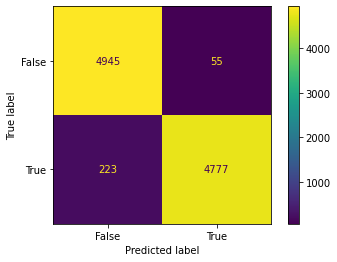

Accuracy: 97.22

Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5000
           1       0.99      0.96      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Test Accuracy:  0.972


In [ ]:
evaluate(unprocessed_final, [xup_test, yup_test])

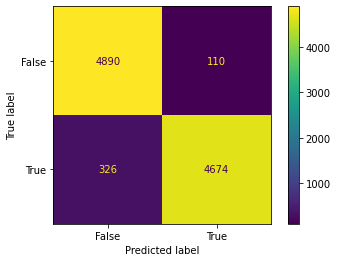

Accuracy: 95.64

Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5000
           1       0.98      0.93      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Test Accuracy:  0.956


In [ ]:
evaluate(preprocessed_final1, [xp_test, yp_test])

The test accuracy of the model based on original data is better than preprocessed data, this might be because the preprocessing of data removed an important part of the data that affects the context of the data itself that contributes to a better learning for the model